# Classification problem
### Considering binary gender classification
(0) Male

(1) Female

In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
import utils as ut

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from neurocombat_sklearn import CombatModel



%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})
np.random.seed(42)

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = pd.DataFrame()

In [4]:
df, phenotypic = ut.import_data(fisher=False)

#df = df.join(pd.DataFrame(phenotypic.Age), how='left')
#df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df['Age'] = phenotypic['Age']

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

df = df.dropna(axis=0)
df = df.reset_index()
df['Site'] = df['Institution'].astype('category')
df['Site'] = df['Site'].cat.codes

# TEST = df[df.Subject.isin(df['Subject'].unique()[-20:])].reset_index()
# X_TEST = TEST.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site','index'])
# y_TEST = TEST.Gender

# df = df[~df.Subject.isin(df['Subject'].unique()[-20:])].reset_index().drop(columns='index')

X = df.drop(columns=['Institution', 'Run', 'Age', 'Gender', 'Subject','Site'])
y = df.Gender.astype(int)


In [5]:
ROI_labels = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/ROI_labels.csv')

In [6]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.39% 
 1 = 0.61%


In [14]:
df_train = df[~df.Subject.isin(np.random.choice(df['Subject'].unique(),100))]
df_test = df[df.Subject.isin(np.random.choice(df['Subject'].unique(),100))]

Age_train = df_train[['Age']]
Site_train = df_train[['Site']]
X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
y_train = df_train.Gender

Age_test = df_test[['Age']]
Site_test = df_test[['Site']]
X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
y_test = df_test.Gender

In [15]:

# Creating model
model = CombatModel()

# Fitting the model and transforming the training set
X_train = model.fit_transform(X_train.values,
                                         Site_train) #X_train_har

# Harmonize test set using training set fitted parameters
X_test = model.transform(X_test.values,
                                    Site_test) #X_test_har

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
X_train, y_train, X_test, y_test = ut.cross_val_data(df, folds=5)

cv = []
for i in range(len(y_train)):
    trainIndices = y_train[i].index.values.astype(int)
    testIndices =  y_test[i].index.values.astype(int)
    cv.append( (trainIndices, testIndices) )

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/

In [22]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")

scores = cross_validate(dummy, X, y, cv=cv, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy in test:0.62(0.08)
F1_scores 0.38(0.03)
Precision_scores 0.31(0.04)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train[1], y_train[1])
y_pred = logreg.predict(X_test[1])

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train[1], logreg.predict(X_train[1]))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test[1], y_pred)))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy score in training set: 1.0000
Logistic Regression accuracy score in val set: 0.7500


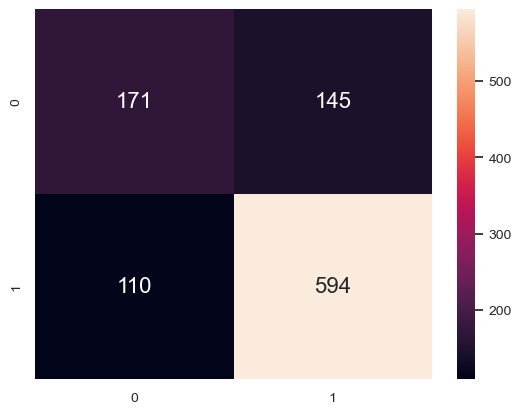

In [9]:
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test[1], y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

### Cross Validation

In [10]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)

scores = cross_validate(logreg, X, y , cv=cv, scoring=scoring, n_jobs=-1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Accuracy in test:0.69(0.04)
F1_scores 0.65(0.03)
Precision_scores 0.66(0.03)
Recall_scores 0.66(0.03)
ROC AUC 0.72(0.05)


In [12]:
scores

{'fit_time': array([56.00413895, 65.10692215, 66.37267494, 66.55984998, 67.13723278]),
 'score_time': array([3.95690703, 1.01991773, 0.696872  , 0.52793813, 0.25733399]),
 'test_acc': array([0.63060897, 0.72941176, 0.67763158, 0.66267943, 0.73255814]),
 'test_prec_macro': array([0.6111188 , 0.68564374, 0.69607843, 0.66603164, 0.65597824]),
 'test_rec_macro': array([0.60769132, 0.69061062, 0.67325017, 0.64612627, 0.65927384]),
 'test_f1': array([0.6087479 , 0.68789911, 0.66630824, 0.64389637, 0.65754477]),
 'test_roc_auc': array([0.62908856, 0.78861748, 0.74056268, 0.72706406, 0.72976815])}

In [11]:
scores['Model'] = ['logreg']*10
results = pd.concat([results, pd.DataFrame.from_dict(scores)],axis=1)

In [2]:
# y_score = logreg.predict_proba(X_test)

# y_score = y_score[:,1]

# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_score)
# roc_auc = auc(fpr, tpr)

In [1]:
# plt.figure()
# lw = 2
# plt.plot(
#     fpr,
#     tpr,
#     color="darkorange",
#     lw=lw,
#     label="ROC curve (area = %0.2f)" % roc_auc,
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
# plt.legend(loc="lower right")
# plt.show()

In [3]:
# # get importance
# importance = logreg.coef_[0]
# importance = np.sort(importance)

# plt.hist(importance)
# plt.show()

## SVM

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "C": [0, 0.25, 1, 5, 10],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
}


svc = SVC(gamma='auto')
#svc.fit(X_train, y_train)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = GridSearchCV(estimator = svc, param_grid = random_grid,
                               cv = 3, verbose=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y.values.ravel())

#y_pred = svc.predict(X_test)

#print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
#print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/si

GridSearchCV(cv=3, estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [0, 0.25, 1, 5, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [13]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 92.13%


In [14]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/SVC_params.csv')

{'C': 0.25, 'kernel': 'linear'}


In [15]:
# Best SVC model
svc = SVC(
    **rf_random.best_params_,
    gamma="auto"
)

scores = cross_validate(svc, X, y.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  3.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.2min finished


In [16]:
print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:0.72(0.03)
F1_scores 0.69(0.04)
Precision_scores 0.70(0.04)
Recall_scores 0.69(0.04)
ROC AUC 0.76(0.05)


In [17]:
scores['Model'] = ['SVC']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [23]:
# svc.fit(X_train,y_train)
# print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy score in TEST set: 0.9967


## MLP

In [53]:
from sklearn.neural_network import MLPClassifier

# Best SVC model
mlp = MLPClassifier(hidden_layer_sizes=(12000,16,2),solver='adam',learning_rate='adaptive', shuffle=False, alpha=1, early_stopping=True)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, mlp.predict(X_train))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
#print('Logistic Regression accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, mlp.predict(X_TEST))))

#scores = cross_validate(mlp, X_train, y_train.values.ravel(), scoring=scoring,
#                         cv=cv, n_jobs=-1,verbose=1)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


AttributeError: 'MLPClassifier' object has no attribute '_best_coefs'

In [ ]:
scores = cross_validate(mlp, X_train, y_train.values.ravel(), scoring=scoring,
                        cv=cv, n_jobs=-1,verbose=1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

In [ ]:
plt.plot(scores['test_acc'])

In [ ]:
scores['Model'] = ['MLP']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

### XGBoost

In [24]:
# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "max_depth": [1, 2, 4, 8],
    "learning_rate": [0.001,0.05, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0.001, 1, 10],
    "scale_pos_weight": [0,1, 3],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]

}

# Using  Boosted trees
bst = XGBClassifier(booster='gbtree',tree_method='exact',objective='binary:logistic',n_jobs=-1)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = bst, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y.values.ravel())


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'gamma': [0, 0.25, 1],
                                        'learning_rate': [0.001, 0.05, 0.5],
                                        'max_depth': [1, 2, 4, 8],
                                        'n_estimators': [200, 600, 1000],
                                        'reg_lambda': [0.001, 1, 10],
                                        'scale_pos_weight': [0, 1, 3],
                                        'subsample': [0.8]},
                   random_state=42, verbose=1)

In [25]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 85.55%


In [18]:
a = {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.001, 'n_estimators': 600,
     'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

In [27]:
a

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'reg_lambda': 0.001,
 'n_estimators': 1000,
 'max_depth': 1,
 'learning_rate': 0.05,
 'gamma': 0.25,
 'colsample_bytree': 0.8}

In [28]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/xgboost_params.csv')

{'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.001, 'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


In [19]:
# Best xgboosting model
final_cl = XGBClassifier(
    **a,
    objective="binary:logistic",
    booster='gbtree',
    tree_method='exact',
    eval_metric='mlogloss',
    n_jobs=-1
)
# **rf_random.best_params_

scores = cross_validate(final_cl, X, y.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)

#bst.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 61.6min remaining: 41.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 80.8min finished


In [20]:
print("Accuracy in val:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, final_cl.predict(X_TEST))))

Accuracy in val:0.68(0.05)
F1_scores 0.61(0.05)
Precision_scores 0.69(0.07)
Recall_scores 0.62(0.04)
ROC AUC 0.74(0.07)


In [21]:
scores['Model'] = ['XGBoost']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [22]:
results

,fit_time,score_time,test_acc,test_prec_macro,test_rec_macro,test_f1,test_roc_auc,Model
0,113.436413,0.464087,0.712838,0.681254,0.678644,0.679862,0.729230,logreg
1,112.223974,0.686256,0.686667,0.702438,0.675000,0.670730,0.785937,logreg
2,109.423476,1.329339,0.667883,0.616609,0.602186,0.605443,0.674570,logreg
3,115.508514,0.317689,0.741525,0.751246,0.724068,0.726681,0.762456,logreg
4,95.381335,1.118333,0.732558,0.716797,0.703316,0.707872,0.767028,logreg
5,115.306455,0.342255,0.737705,0.701113,0.692835,0.696399,0.790777,logreg
6,96.783327,0.703600,0.690265,0.656629,0.641610,0.645895,0.685360,logreg
7,114.693554,0.365203,0.788660,0.791652,0.775649,0.779759,0.841017,logreg
8,25.108315,0.209200,0.758824,0.716417,0.718709,0.717528,0.816982,logreg
9,24.267210,0.204222,0.681818,0.705409,0.674493,0.666505,0.807770,logreg


In [24]:
results.to_csv('/Users/rodrigo/Post-Grad/CC400/Results/models.csv')

In [213]:
test = pd.DataFrame(np.random.random_integers(1,5,1000)).replace({1 : 'A', 2: 'B', 3 : 'C', 4 : 'D', 5 : 'E'}).rename(columns={0 : 'Feature 1'})

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_83961/1989914074.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 5 + 1) instead
  test = pd.DataFrame(np.random.random_integers(1,5,1000)).replace({1 : 'A', 2: 'B', 3 : 'C', 4 : 'D', 5 : 'E'}).rename(columns={0 : 'Feature 1'})


In [214]:
test['Target'] = np.random.random_integers(0,1,1000)

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_83961/2000890065.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  test['Target'] = np.random.random_integers(0,1,1000)


In [215]:
#test['Target'] = (test['Feature 1'] == 'B') | (test['Feature 1'] == 'D')

In [216]:
#test = test.replace({True : 1, False : 0})

In [217]:
#choice = np.random.choice(np.array(test[(test['Feature 1'] == 'A')].index), 25)

In [218]:
#test.loc[choice, 'Target'] = [1]*len(choice) 

In [219]:
test

,Feature 1,Target
0,D,1
1,D,1
2,C,1
3,A,0
4,D,0
...,...,...
995,E,0
996,C,0
997,E,0
998,B,1


<Axes: xlabel='Feature 1', ylabel='Target'>

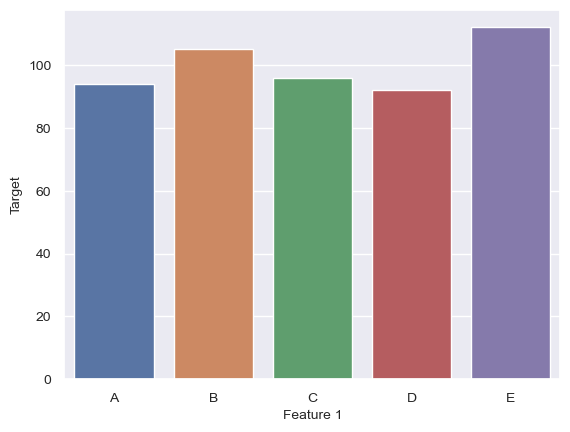

In [206]:
sns.barplot((test.groupby('Feature 1').sum()).reset_index(),x='Feature 1', y = 'Target')

In [207]:
##Entropy
def entropy(Y):
    """
    Shanon Entropy
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

#Joint Entropy
def jEntropy(Y,X):
    """
    H(Y;X)
    """
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def cEntropy(Y, X):
    """
    H(Y|X) = H(Y;X) - H(X)
    """
    return jEntropy(Y, X) - entropy(X)


#Mutual Information
def Mutual_Info(Y, X):
    """
    I(Y;X) = H(Y) - H(Y|X)
    """
    return entropy(Y) - cEntropy(Y,X)

In [208]:
def mutual_info_matrix(df):
    mutual_info = pd.DataFrame()
    list_aux = {}
    for col in df.columns:
        for col_2 in df.columns:
            I_XY = Mutual_Info(df[col],df[col_2])
            list_aux[col_2] = [I_XY]
        aux = pd.DataFrame.from_dict(list_aux)
        aux['index'] = col
        aux = aux.set_index('index')
        mutual_info = pd.concat([mutual_info, aux])
    return mutual_info

In [209]:
test = test.replace({'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5})

In [210]:
mutual_info = mutual_info_matrix(test)

In [211]:
mutual_info

,Feature 1,Target
index,,
Feature 1,2.321243,0.001627
Target,0.001627,0.999997


In [185]:
##Entropy
def entropy(Y):
    """
    Shanon Entropy
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en